In [ ]:
from utils.utils import get_config, get_distribution_dataframe
import os
config_path = 'config/spec.yaml'
config = get_config(config_path)
gpu = config['train']['gpu']
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)

: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from model import SpecNet
from dataset import SpecDataset
from train import train, predict, test
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

In [3]:
seed = 10
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True

In [4]:
base_dir = config['base']['base_dir']
data_dir = config['base']['data_dir']
batch_size = config['train']['batch_size']
lr = float(config['train']['lr'])
num_epoch = config['train']['epoch']
rate = config['train']['rate']
subject = config['base']['subject']
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [5]:
train_dataset = SpecDataset(os.path.join(base_dir, 'data', f'spec{subject}'), mode='train')
valid_dataset = SpecDataset(os.path.join(base_dir, 'data', f'spec{subject}'), mode='valid')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(len(train_dataloader), len(valid_dataloader))

Initialize spec train dataset including 14140 records of 15 people.
Initialize spec valid dataset including 3597 records of 15 people.
221 57


In [6]:
model = SpecNet(out_num=subject)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=5e-4)
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train(model=model, num_epoch=num_epoch, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=optimizer, device=device, log_interval=5, save_dir=data_dir, continue_index=6)

Load checkpoint from /mnt/traffic/maruokai/datasets/pd_data/checkpoint/6, and training will begin in epoch 550


Epoch:[555/560]	 train_loss=0.98644	 train_acc=0.7059 	 valid_loss=1.06037	 valid_acc=0.7081


Epoch:[560/560]	 train_loss=0.97559	 train_acc=0.7087 	 valid_loss=1.02915	 valid_acc=0.7120
best accuracy: 0.7120, best epoch: 560


In [7]:
ckpt_dir = '/mnt/traffic/maruokai/datasets/pd_data/checkpoint/6'
state =torch.load(os.path.join(ckpt_dir, 'best_ckpt.pth'))
model = SpecNet(out_num=subject)
best_acc = state['acc']
best_epoch = state['epoch']
model.load_state_dict(state['model'])
y_pred, y_true = predict(model, valid_dataloader, device)
print(f'Best acc: {best_acc}, best epoch: {best_epoch}')


Best acc: 0.7119822073950515, best epoch: 560


In [8]:
acc = metrics.accuracy_score(y_pred, y_true)
acc

0.7119822073950515

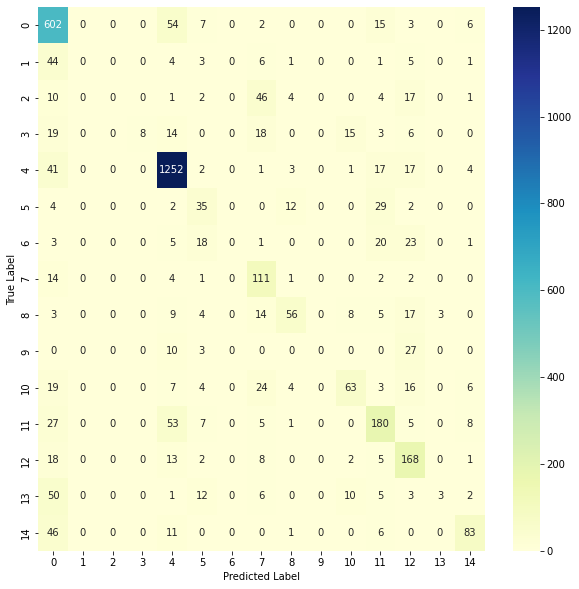

In [17]:
fig_dir = os.path.join('figure', f'spec{subject}')
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(fig_dir, 'confusion_matrix'))

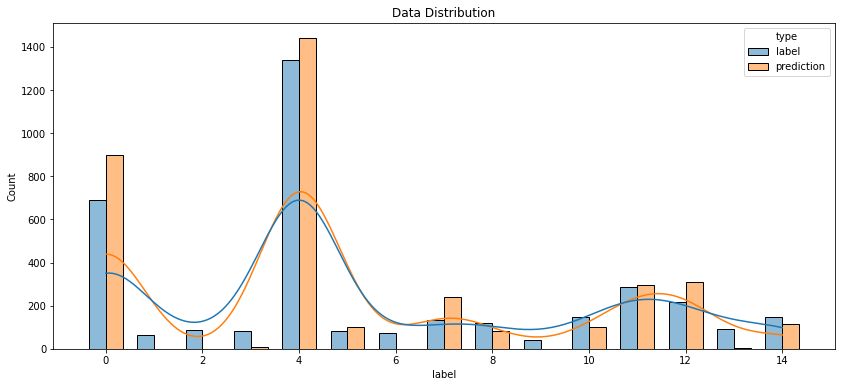

In [18]:
df = get_distribution_dataframe(y_true, y_pred)
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='label', hue='type', multiple='dodge', discrete=True, shrink=.7, kde=True)

plt.title('Data Distribution')
plt.savefig(os.path.join(fig_dir, 'data_distribution'))


In [13]:
print(metrics.classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.87      0.76       689
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00        85
           3       1.00      0.10      0.18        83
           4       0.87      0.94      0.90      1338
           5       0.35      0.42      0.38        84
           6       0.00      0.00      0.00        71
           7       0.46      0.82      0.59       135
           8       0.67      0.47      0.55       119
           9       0.00      0.00      0.00        40
          10       0.64      0.43      0.51       146
          11       0.61      0.63      0.62       286
          12       0.54      0.77      0.64       217
          13       0.50      0.03      0.06        92
          14       0.73      0.56      0.64       147

    accuracy                           0.71      3597
   macro avg       0.47      0.40      0.39      3597
weighted avg       0.67   

/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/traffic/maruokai/conda/envs/pd/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

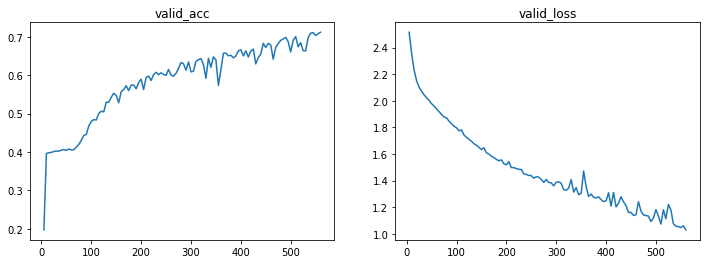

In [16]:
valid_acc_dict = dict()
valid_loss_dict = dict()
l = os.listdir(ckpt_dir)
for item in l:
    if item.startswith('epoch'):
        valid_acc_dict[int(item[:-4].split('_')[1])]=float(item[:-4].split('_')[5])
        valid_loss_dict[int(item[:-4].split('_')[1])]=float(item[:-4].split('_')[3])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=valid_acc_dict)
plt.title('valid_acc')
plt.subplot(1, 2, 2)
sns.lineplot(data=valid_loss_dict)
plt.title('valid_loss')
plt.savefig(os.path.join(fig_dir, 'valid_trend'))